# Baseline Forecasting for Steel Price Index
This notebook builds simple baseline forecasting models for the monthly steel Producer Price Index (PPI_STEEL). The goal is to establish reference performance before moving to more advanced models (ARIMA, ETS, machine learning, etc.).
We follow this sequence:
1. Load the steel time series from the database.
2. Hold out the most recent 24 months as a test set (simulate future).
3. Fit / construct simple baseline forecasts on the training set only.
4. Compare predictions against the test set with intuitive error metrics.
5. Interpret results and outline next modeling steps.

Steel data loaded successfully:


,value
date,
1982-06-01,100.0
1982-07-01,100.0
1982-08-01,100.0
1982-09-01,100.0
1982-10-01,99.6


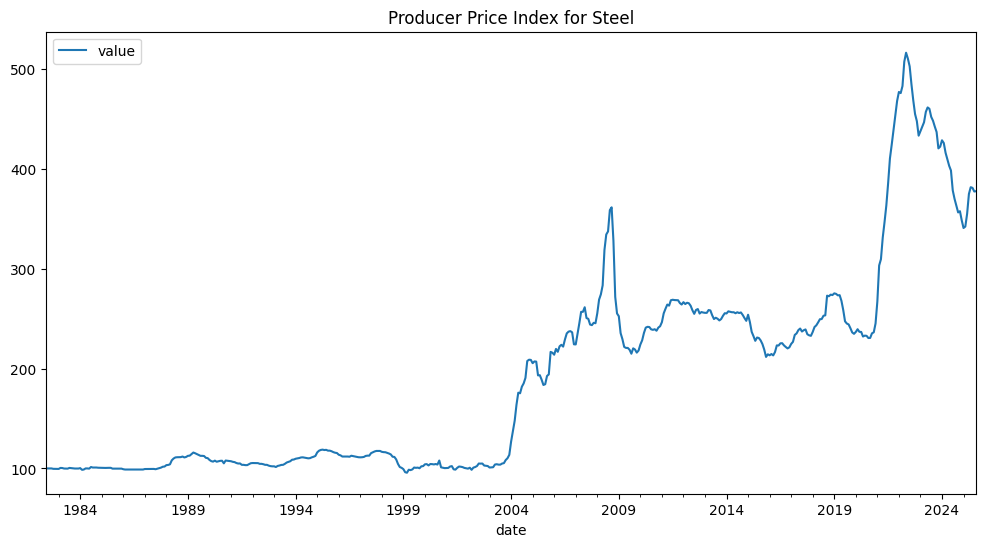

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# --- 1. SETUP & LOAD DATA ---
# Robust project root finder (works in notebook context)
def find_project_root(markers=(".env", "pyproject.toml", ".git")):
    start = Path.cwd().resolve()
    for parent in [start, *start.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    raise RuntimeError("Project root with one of markers not found.")

project_root = find_project_root()
dotenv_path = project_root / '.env'
load_dotenv(dotenv_path=dotenv_path)

DATABASE_URL = os.getenv("DATABASE_URL_ALEMBIC") or os.getenv("DATABASE_URL")
if not DATABASE_URL:
    raise ValueError("DATABASE_URL_ALEMBIC or DATABASE_URL not set in .env")

engine = create_engine(DATABASE_URL)

# Load only the steel data, set the date as the index
query = "SELECT date, value FROM raw_series WHERE series_id = 'PPI_STEEL' ORDER BY date"
steel_df = pd.read_sql(query, engine, index_col='date')
steel_df.index = pd.to_datetime(steel_df.index)
steel_df = steel_df.asfreq('MS')  # Ensure monthly frequency

print("Steel data loaded successfully:")
display(steel_df.head())
steel_df.plot(figsize=(12, 6), title='Producer Price Index for Steel')
plt.show()

### Data Overview & First Look
The steel PPI series shows an overall upward drift with noticeable spikes (likely supply shocks / pandemic disruptions).
Why this matters:
- Upward trend means level-based errors can be misleading; scale-aware metrics help.
- Spikes can hurt naive averages; seasonal or robust methods may handle them better.
Before modeling we ensure:
- Monthly frequency enforced (`asfreq('MS')`).
- Index is datetime (done in load cell).
Next: create a realistic train/test split to simulate forecasting future unseen months.

Training data points: 495
Test data points: 24


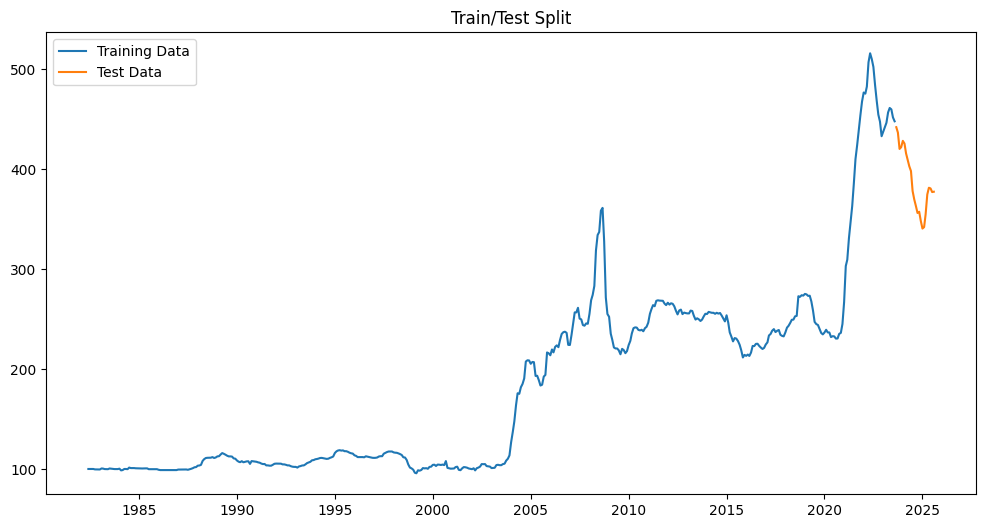

In [6]:
# --- 2. TRAIN/TEST SPLIT ---
split_point = len(steel_df) - 24
train, test = steel_df[0:split_point], steel_df[split_point:]

print(f"Training data points: {len(train)}")
print(f"Test data points: {len(test)}")

# Plot the split
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.title('Train/Test Split')
plt.legend()
plt.show()

### Split Plot Interpretation
Visual check confirms:
- Training segment captures long-run trend and earlier volatility regimes.
- Test window includes recent dynamics we want to forecast (potentially different level/variance).
- No obvious discontinuity at boundary (good sign against data glitches).
Next: Build three lightweight baseline forecasts to set a performance floor.

### Train/Test Strategy
We hold out the most recent 24 months as a proxy for "future" data:
- 24 months gives enough horizon to evaluate seasonal behavior.
- Training set remains long enough to capture structural trend and prior volatility.
Assumption: No data leakage (we never peek at test values when forming baselines).
Next cell performs the split and visual confirmation.

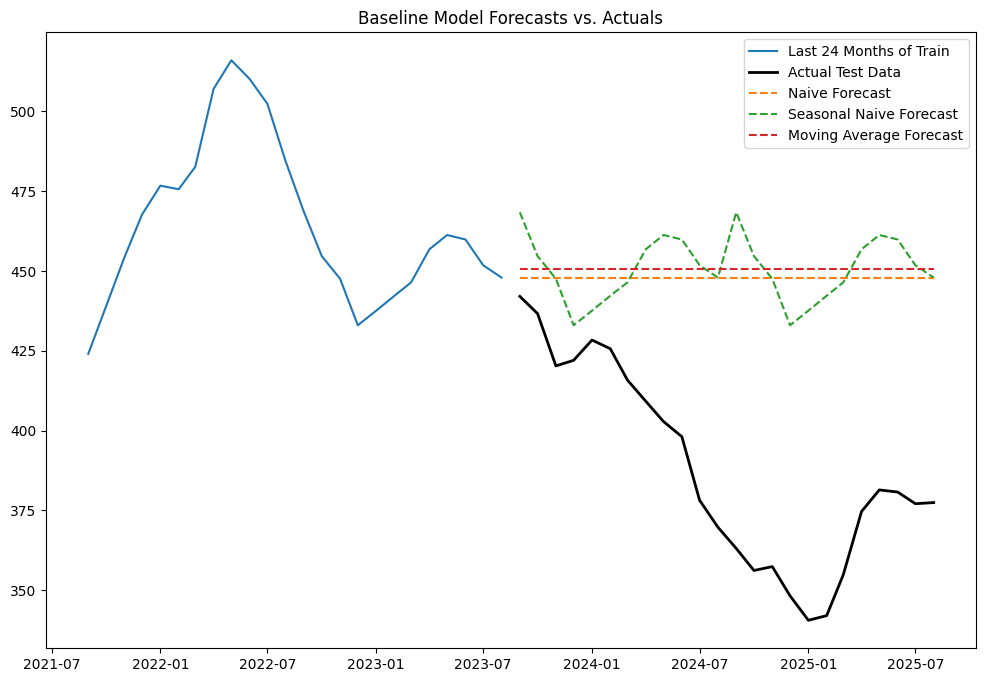

In [9]:
# --- 3. BASELINE MODELS ---
# Naive Forecast
naive_forecast = pd.Series(train['value'].iloc[-1], index=test.index)

# Seasonal Naive Forecast (12-month seasonality)
seasonal_naive_forecast = train['value'].iloc[-12:].values
# Repeat the last 12 months for the next 24 months
seasonal_forecast_values = np.tile(seasonal_naive_forecast, 2) 
seasonal_naive_forecast = pd.Series(seasonal_forecast_values, index=test.index)

# Moving Average Forecast (12-month window)
moving_avg_forecast = train['value'].rolling(12).mean().iloc[-1]
moving_avg_forecast = pd.Series(moving_avg_forecast, index=test.index)

# Plot the forecasts against the actual test data
plt.figure(figsize=(12, 8))
plt.plot(train.tail(24), label='Last 24 Months of Train')
plt.plot(test, label='Actual Test Data', color='black', linewidth=2)
plt.plot(naive_forecast, label='Naive Forecast', linestyle='--')
plt.plot(seasonal_naive_forecast, label='Seasonal Naive Forecast', linestyle='--')
plt.plot(moving_avg_forecast, label='Moving Average Forecast', linestyle='--')
plt.title('Baseline Model Forecasts vs. Actuals')
plt.legend()
plt.show()

### Baseline Forecasts Overview
We now create three ultra-simple forecast benchmarks. Their purpose is not to be "good" but to define the minimum a serious model must beat.

**Why start with baselines?** If a complex model cannot outperform these, it's either overfitting noise or not exploiting structure (trend / seasonality) at all.

| Method | Plain Description | Strength | Weakness | Mental Analogy |
|--------|-------------------|----------|----------|----------------|
| Naive | Future = last observed value | Ultra-fast, hard to beat in short horizons | Ignores trend & seasonality | "Freeze the last frame" |
| Seasonal Naive | Future month = value from same month last year | Captures stable yearly pattern | Fails if pattern shifted or disrupted | "Desk calendar rewind" |
| 12-Month Moving Avg | Future = average of last 12 months | Smooths noise, robust to outliers | Lags turns, ignores seasonality shape | "Long exposure blur" |

> Key expectation: Seasonal naive should only help if steel prices exhibit a repeating yearly rhythm; moving average should underreact during sudden up or down shifts.

#### Failure Modes
- Structural break (e.g., supply shock): all three will lag or miss level shifts.
- Emerging trend acceleration: naive underestimates slope; moving average lags more; seasonal naive may misalign.
- Regime change in volatility: moving average hides it; naive can look erratic relative to reality.

#### Why Keep Them
They define a performance floor. Any advanced approach (ARIMA / SARIMAX / ETS / ML) must deliver lower error (sMAPE, MASE) than at least the best of these. Otherwise, added complexity isn't justified.

Next: Generate and plot these forecasts, then interpret the visual fit before measuring error.

### Forecast Plot Interpretation
Visual comparison shows:
- Naive forecast stays flat; diverges when trend or level shifts occur in test period.
- Seasonal naive introduces variation, useful only if actual seasonality repeats; may misalign if recent pattern shifted.
- Moving average is the smoothest and slowest—lags any recent acceleration or deceleration.
None of these adapt to structural shifts; they provide a baseline, not a final solution. Next, we quantify errors.

In [11]:
# --- 4. CALCULATE METRICS ---
def calculate_smape(actual, predicted):
    return np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted))) * 100

def calculate_mase(actual, predicted, train_actual):
    mae_model = np.mean(np.abs(actual - predicted))
    mae_naive_in_sample = np.mean(np.abs(train_actual[1:] - train_actual[:-1]))
    return mae_model / mae_naive_in_sample

# Calculate metrics for each model
results = {}
models = {
    'Naive': naive_forecast,
    'Seasonal Naive': seasonal_naive_forecast,
    'Moving Average': moving_avg_forecast
}

for name, forecast in models.items():
    smape = calculate_smape(test['value'], forecast)
    mase = calculate_mase(test['value'], forecast, train['value'].values)
    results[name] = {'sMAPE': smape, 'MASE': mase}

results_df = pd.DataFrame(results).T
print("Baseline Model Performance Metrics:")
display(results_df)

Baseline Model Performance Metrics:


,sMAPE,MASE
Naive,14.726271,20.155296
Seasonal Naive,15.298558,21.054167
Moving Average,15.320726,21.054167


### Metrics Interpretation & Next Steps
Reading the table:
- Lower sMAPE = closer average percentage fit; lower MASE (<1) = better than naive differencing benchmark.
- Compare which baseline achieves the smallest sMAPE and MASE; that becomes our reference floor.
Common outcomes:
- Moving average may underperform if trend accelerates.
- Seasonal naive may help only if strong repeating yearly pattern exists.
If all baselines have relatively high error, advanced models (e.g., STL + ETS, SARIMAX, Prophet, gradient boosting on engineered features) have room to improve.
Next planned enhancements:
1. Add drift / linear trend baseline and simple exponential smoothing.
2. Test stationarity and difference/log-transform if needed.
3. Introduce cross-validation over rolling origin splits for robustness.
4. Bootstrap prediction intervals for uncertainty communication.

### Error Metrics Chosen
We evaluate with two scale-aware metrics:
- sMAPE (%): Symmetric Mean Absolute Percentage Error; interpretable as average % deviation. Handles scale changes better than plain MAPE.
- MASE (unitless): Mean Absolute Scaled Error; compares model MAE to a naive one-step lag benchmark (<1 means improvement over naive).
Using both guards against misleading conclusions when level shifts or near-zero values would skew pure percentage metrics.